<h3><b>VIDEO RATINGS ANALYSIS</b></h3>
<p>Takes the video ratings scores for the three outcomes (fear, disgust and points) at two timepoints (for fear and disgust:only one rating for points)</p>
<p>Carries out the checks using mixed effects models, as specified in the analysis plan (as well as detailing what is expected from these checks)</p>
<br>
<p>NB this current version is run on fake data - randomly generated (so won't see any expected effects)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import jsonlines
from functools import reduce
import statistics
import scipy.stats
import seaborn as sns
import math
import os
import json
import ast
import matplotlib.patches as mpatches
import statsmodels.api as sm
import statsmodels.formula.api as smf
from numpy import std, mean, sqrt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.copy_on_write = True

In [2]:
chosen_stim_df = pd.read_csv("csvs/chosen_stim_excluded.csv")
chosen_stim_df.drop('Unnamed: 0', axis="columns", inplace=True)

In [5]:
#create long form df which allows for this
long_chosen_stim_df=pd.DataFrame()
for i in chosen_stim_df.index:
    row=chosen_stim_df.loc[i]
    #timepoint=['unpleasan']
    timepoint_1=pd.DataFrame({
    'participant_no': [row.participant_no],
    'age': [row.prolific_age],
    'sex': [row. prolific_sex],
    'Vid': [str(row['Vid'])],
    'trial_type': [row.trial_type],
    'Valence': [row.unpleasant_1],
    'Arousal': [row.arousing_1],
    'Fear': [row.frightening_1],
    'Disgust': [row.disgusting_1],
    'Timepoint': 1.0
    })
    timepoint_2=pd.DataFrame({
        'participant_no': [row.participant_no],
        'age': [row.prolific_age],
        'sex': [row. prolific_sex],
        'Vid': [str(row['Vid'])],
        'trial_type': [row.trial_type],
        'Valence': [row.unpleasant_2],
        'Arousal': [row.arousing_2],
        'Fear': [row.frightening_2],
        'Disgust': [row.disgusting_2],
        'Timepoint': 2.0
    })
    long_chosen_stim_df_row=pd.concat([timepoint_1, timepoint_2])
    long_chosen_stim_df=pd.concat([long_chosen_stim_df_row, long_chosen_stim_df])
    long_chosen_stim_df=long_chosen_stim_df[long_chosen_stim_df.trial_type!="points"]

<b>1. ANALYSING THE CHOSEN STIMULI (Fear and disgust)</b>
<p> Doing this using 4 mixed effects models - testing effect of timepoint and stimulus type on ratings </p>
<p>List of models to run:
<li> A) 'Valence ~ trial_type*Timepoint'
<li> B) 'Arousal ~ trial_type*Timepoint'
<li> C) 'Disgust ~ trial_type*Timepoint'
<li> D) 'Fear ~ trial_type*Timepoint'

Model A: Valence ~ trial_type*Timepoint

In [6]:
##Test the fit of different variations of model A
data=long_chosen_stim_df.reset_index()
data.replace(['disgust', 'fear'], [1.0,2.0], inplace=True)

formula = 'Valence ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)


     randslope  vid_randint_randslope  basic_model  vid_randint
0  5450.343298            5457.558538  5467.191008  5566.195514


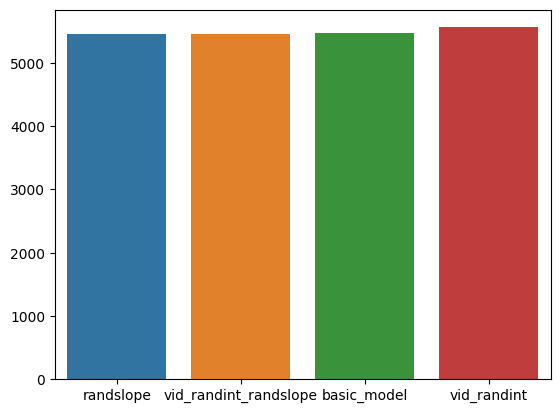

In [12]:
#test which random effects to include
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, randslope is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0   5450.343298     5453.27167    5456.832328        5459.830669


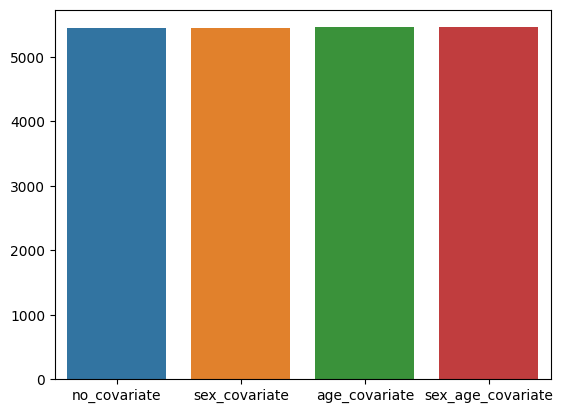

In [13]:
##test which covariates to add -- Using the random effects which were best above
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [14]:
#Hypothesis test using this model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:               MixedLM    Dependent Variable:    Valence   
No. Observations:    1360       Method:                ML        
No. Groups:          340        Scale:                 1.8645    
Min. group size:     4          Log-Likelihood:        -2696.3107
Max. group size:     4          Converged:             Yes       
Mean group size:     4.0                                         
-----------------------------------------------------------------
                       Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------
Intercept               6.318    0.381 16.590 0.000  5.571  7.064
trial_type             -0.488    0.240 -2.033 0.042 -0.959 -0.018
Timepoint               0.224    0.234  0.955 0.340 -0.235  0.683
trial_type:Timepoint   -0.329    0.148 -2.224 0.026 -0.620 -0.039
Group Var               2.692    0.506                           
Group x trial_type Cov -0.975    0.279                           
trial_type Var          0.959    0.194                           
=================================================================

"""

Now do the same for model B: Arousal ~ trial_type*Timepoint

In [15]:
##mixed effects model Arousal (model B)
formula = 'Arousal ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

In [18]:
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [19]:
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


   basic_model  vid_randint            randslope vid_randint_randslope
0  5051.633916  5273.516342  CONVERGENCE WARNING   CONVERGENCE WARNING


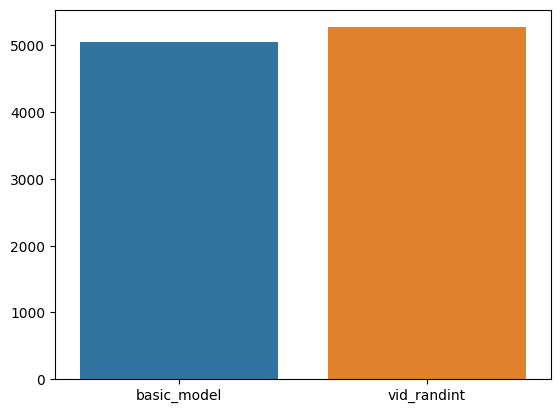

In [22]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False) CONVERGENCE WARNING
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False) #CONVERGENCE WARNING

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, basic model is best

   age_covariate  sex_age_covariate  no_covariate  sex_covariate
0    5269.358961        5270.052938   5273.516342    5273.955483


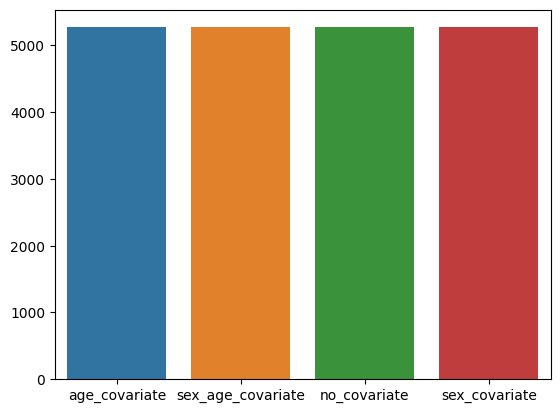

In [23]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is the best

In [24]:
#Hypothesis test using this model
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   Arousal   
No. Observations:    1360      Method:               ML        
No. Groups:          340       Scale:                1.6162    
Min. group size:     4         Log-Likelihood:       -2609.4261
Max. group size:     4         Converged:            Yes       
Mean group size:     4.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             3.981    0.413  9.642 0.000  3.172  4.791
trial_type            0.594    0.237  2.506 0.012  0.129  1.059
Timepoint            -0.165    0.218 -0.755 0.450 -0.592  0.263
trial_type:Timepoint -0.215    0.138 -1.557 0.119 -0.485  0.056
age                   0.013    0.004  3.386 0.001  0.006  0.021
Vid Var               1.476    0.138                           
===============================================================

"""

In [25]:
#Hypothesis test using this model (and with no_covariates anyways if this isn't the best model)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   Arousal   
No. Observations:    1360      Method:               ML        
No. Groups:          340       Scale:                1.6162    
Min. group size:     4         Log-Likelihood:       -2615.1125
Max. group size:     4         Converged:            Yes       
Mean group size:     4.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.568    0.376 12.160 0.000  3.831  5.304
trial_type            0.594    0.238  2.501 0.012  0.128  1.060
Timepoint            -0.165    0.218 -0.755 0.450 -0.592  0.263
trial_type:Timepoint -0.215    0.138 -1.557 0.119 -0.485  0.056
Vid Var               1.514    0.140                           
===============================================================

"""

Model C: Disgust ~ trial_type*Timepoint

In [28]:
##mixed effects model Disgust (model C)
formula = 'Disgust ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

     randslope  vid_randint  vid_randint_randslope  basic_model
0  5166.185475    5173.3827            5173.400714  5293.322268


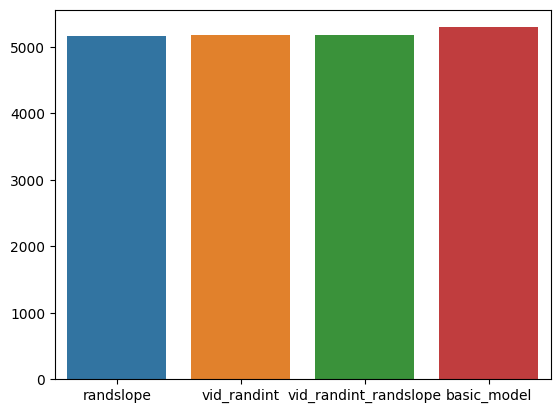

In [29]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##randslope is best fitting

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   5166.185475    5171.280346    5172.462865        5177.585387


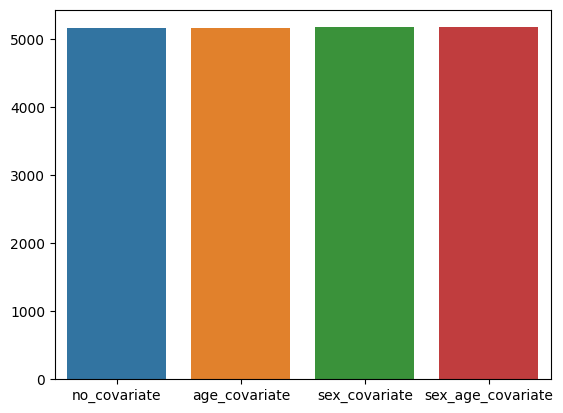

In [31]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [32]:
#Hypothesis test using this model (and with no_covariates anyways if this isn't the best model)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    Disgust   
No. Observations:     1360       Method:                ML        
No. Groups:           340        Scale:                 1.3046    
Min. group size:      4          Log-Likelihood:        -2554.2318
Max. group size:      4          Converged:             Yes       
Mean group size:      4.0                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              12.262    0.343  35.743 0.000 11.589 12.934
trial_type             -5.762    0.214 -26.953 0.000 -6.181 -5.343
Timepoint              -0.888    0.196  -4.535 0.000 -1.272 -0.504
trial_type:Timepoint    0.582    0.124   4.701 0.000  0.340  0.825
Group Var               7.398    0.877                            
Group x trial_type Cov -3.932    0.498                            
trial_type Var          2.492    0.312                            
==================================================================

"""

Finally - model D: Fear ~ trial_type*Timepoint

In [33]:
##mixed effects model Fear (model D)
formula = 'Fear ~ trial_type*Timepoint'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

     randslope  vid_randint_randslope  vid_randint  basic_model
0  5497.603288            5504.818527  5540.669101   5648.19592


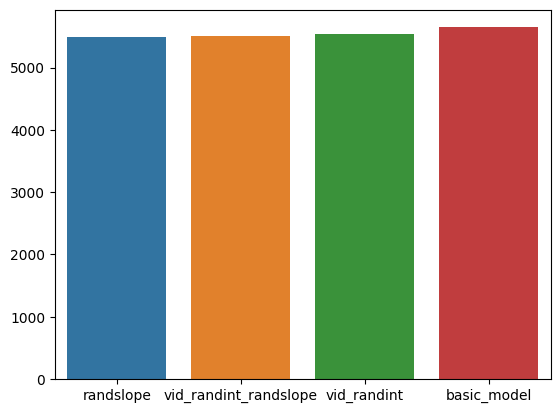

In [34]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##randslope is best

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   5497.603288    5498.456511    5504.703735        5505.549418


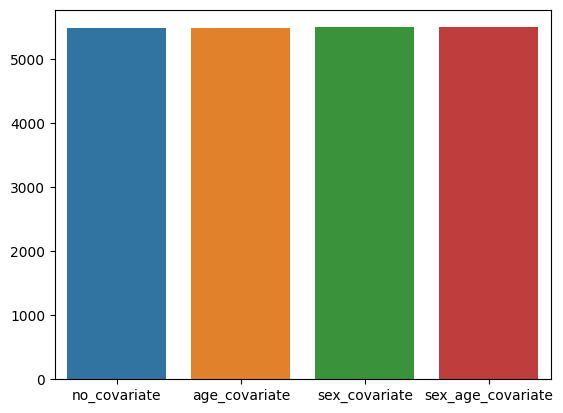

In [35]:
##test which covariates to add -- Using the random effects which were best above (vid_rantint)
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+sex+age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, nocovariate is the best

In [36]:
#Hypothesis test using this model (and with no_covariates anyways if this isn't the best model)
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:                MixedLM    Dependent Variable:    Fear      
No. Observations:     1360       Method:                ML        
No. Groups:           340        Scale:                 1.4539    
Min. group size:      4          Log-Likelihood:        -2719.9407
Max. group size:      4          Converged:             Yes       
Mean group size:      4.0                                         
------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept              -4.576    0.366 -12.511 0.000 -5.293 -3.860
trial_type              5.391    0.228  23.613 0.000  4.944  5.839
Timepoint               1.671    0.207   8.079 0.000  1.265  2.076
trial_type:Timepoint   -1.124    0.131  -8.591 0.000 -1.380 -0.867
Group Var               9.150    0.996                            
Group x trial_type Cov -4.671    0.557                            
trial_type Var          3.185    0.361                            
==================================================================

"""

<b>Interpretation of these models:</b>
<li>Expect matched valence and arousal across fear and disgusting video types (no effect of video type in models A+B)
<li>Expect differences in fear and disgust ratings across video types (effect of video type in models C+D)
<li>Expect some habituation of ratings (an effect of time) (effect of time in models A,B,C, or D)
<li> Might be different habituation between fear and disgust (fear*time interaction in models A,B,C,or D)
<br>
<p>Followup analyses in main hypothesis testing required:(models 1-6 in task_model_free_analysis) </p>
<li>If there is a difference in valence and arousal across fear and disgusting videos: add this difference as a covariate (fear(T1)-disgust(T1))
<li>If there is a difference in habituation between fear and disgusting videos: add this difference in habituation as a covariate (Fear(T1-T2) - Disgust(T1-T2))

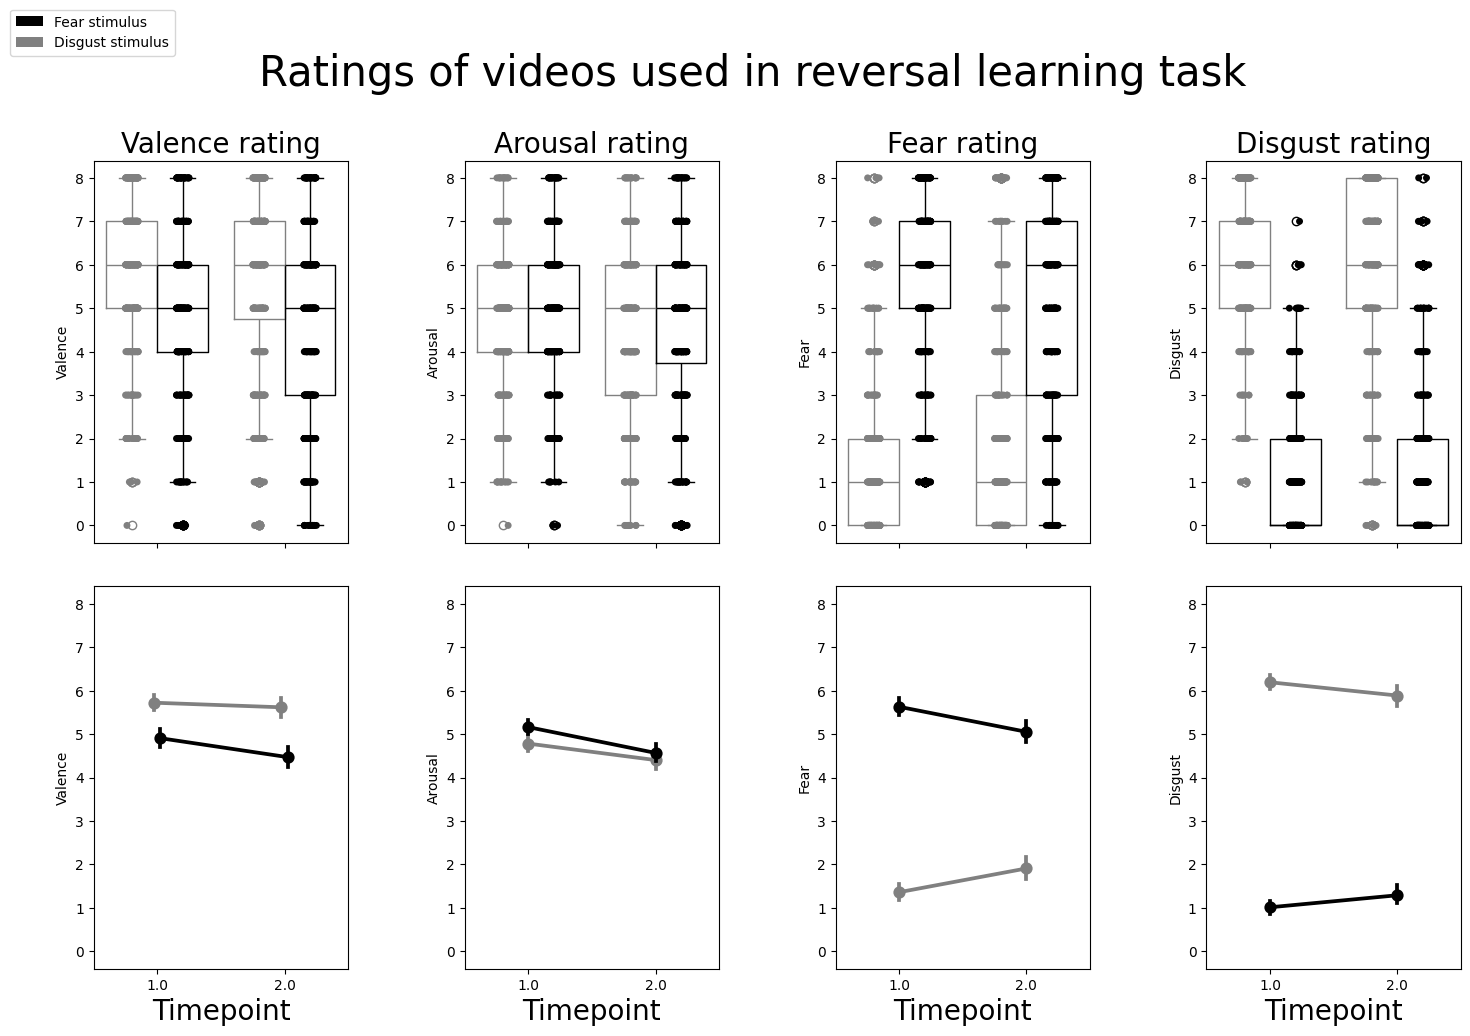

In [37]:
#example plot for this data
fig, axes = plt.subplots(2,4, sharex='col', sharey='col')
title="Ratings of videos used in reversal learning task"
plt.suptitle(title, fontsize=30)
fig.tight_layout(pad=0.5)
fig.set_size_inches(15, 10)

palette = {'fear': '0',
            'disgust': '0.5'}
sns.stripplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,0], x='Timepoint', y='Valence', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,0].get_legend().set_visible(False)
axes[0,0].set_title("Valence rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,0], x='Timepoint', y='Valence', hue='trial_type', dodge=True, palette=palette)
axes[1,0].get_legend().set_visible(False)
axes[1,0].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,1], x='Timepoint', y='Arousal', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,1].get_legend().set_visible(False)
axes[0,1].set_title("Arousal rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,1], x='Timepoint', y='Arousal', hue='trial_type', dodge=False, palette=palette)
axes[1,1].get_legend().set_visible(False)
axes[1,1].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,2], x='Timepoint', y='Fear', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,2].get_legend().set_visible(False)
axes[0,2].set_title("Fear rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,2], x='Timepoint', y='Fear', hue='trial_type', dodge=False, palette=palette)
axes[1,2].get_legend().set_visible(False)
axes[1,2].xaxis.get_label().set_fontsize(20)

sns.stripplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=True, palette=palette)
sns.boxplot(data=long_chosen_stim_df, ax=axes[0,3], x='Timepoint', y='Disgust', hue='trial_type', fill=False, palette=palette, linewidth=1)
axes[0,3].get_legend().set_visible(False)
axes[0,3].set_title("Disgust rating", fontsize=20) 

sns.pointplot(data=long_chosen_stim_df, ax=axes[1,3], x='Timepoint', y='Disgust', hue='trial_type', dodge=False, palette=palette)
axes[1,3].get_legend().set_visible(False)
axes[1,3].xaxis.get_label().set_fontsize(20)

plt.figlegend(loc='center left', bbox_to_anchor=(0,1),  handles=[mpatches.Patch(facecolor='0'), mpatches.Patch(facecolor='0.5')], labels=['Fear stimulus', 'Disgust stimulus'])
plt.show()

<b>2. CHECK POINTS RATINGS</b>
<p>Aim: check whether points block differs from other blocks in terms of ratings (at T1) - a sanity check</p>
<p>List of models to run: </p>
<li> E) 'Valence ~ trial_type'
<li> F) 'Arousal ~ trial_type'
<li> G) 'Disgust~ trial_type'
<li> H) 'Fear ~ trial_type'

Model E: 'unpleasant_1 (valence) ~ trial_type'

In [38]:
#Model E
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1', 'Vid', 'prolific_age', 'prolific_sex']]

formula = 'unpleasant_1 ~ trial_type'

model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

In [40]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


In [41]:
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [42]:
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

   basic_model          vid_randint           randslope vid_randint_randslope
0  4480.762569  CONVERGENCE WARNING  CONVERENCE WARNING   CONVERGENCE WARNING


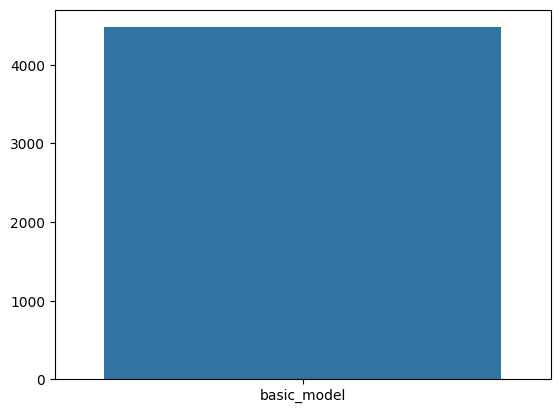

In [43]:
#test random effects
#vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False) CONVERGENCE WARNING
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False) ##CONVERGENCE WARNING
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': ['CONVERGENCE WARNING'], 
                    'randslope': ['CONVERENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, basic model is best

   no_covariate  sex_covariate  age_covariate  sex_age_covariate
0   4480.762569     4482.15133    4487.024662        4488.481825


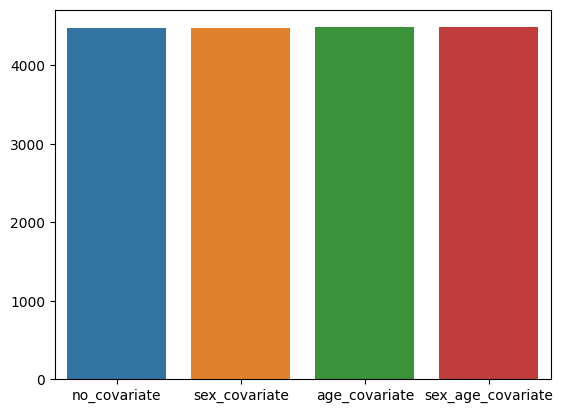

In [44]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic)
print(bic) ##in this case, just the no covariate is best

In [45]:
#Hypothesis test using this model
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
================================================================
Model:              MixedLM   Dependent Variable:   unpleasant_1
No. Observations:   1020      Method:               ML          
No. Groups:         340       Scale:                3.8257      
Min. group size:    3         Log-Likelihood:       -2223.0624  
Max. group size:    3         Converged:            Yes         
Mean group size:    3.0                                         
----------------------------------------------------------------
                     Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------------
Intercept             5.724    0.118  48.503 0.000  5.492  5.955
trial_type[T.fear]   -0.818    0.150  -5.450 0.000 -1.112 -0.524
trial_type[T.points] -2.171    0.150 -14.469 0.000 -2.465 -1.877
Group Var             0.909    0.105                            
================================================================

"""

Model F: arousing_1 ~ trial_type

In [46]:
#Model F
formula = 'arousing_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

In [49]:
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

In [50]:
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed t

   basic_model  vid_randint            randslope vid_randint_randslope
0  4339.818454  4361.518542  CONVERGENCE WARNING   CONVERGENCE WARNING


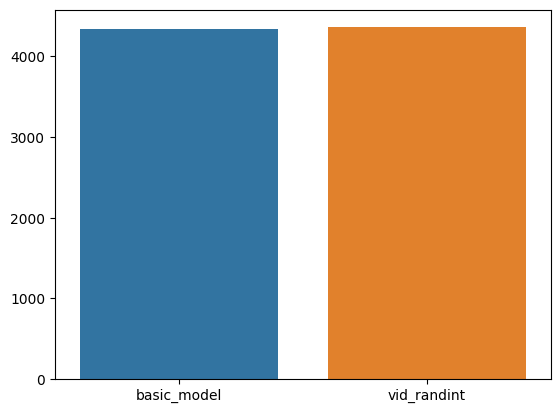

In [51]:
#test random effects
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)
#randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False) CONVERGENCE WARNING
#vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False) CONVERGENCE WARNING

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': [vid_randint.bic], 
                    'randslope': ['CONVERGENCE WARNING'],
                    'vid_randint_randslope':['CONVERGENCE WARNING']})
sns.barplot(bic)
print(bic) ##in this case, basic model

   age_covariate  no_covariate  sex_age_covariate  sex_covariate
0    4335.169186   4339.818454        4340.716675    4345.242894


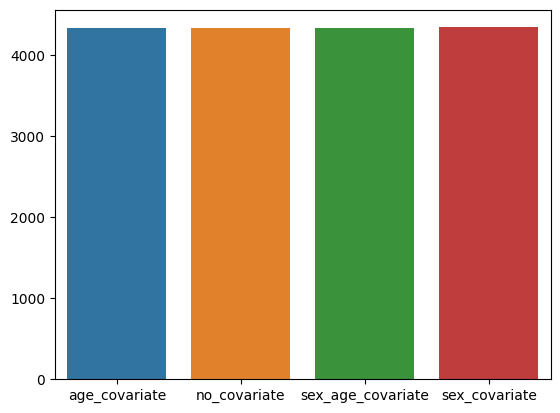

In [53]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate

In [54]:
#Hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   arousing_1
No. Observations:    1020      Method:               ML        
No. Groups:          340       Scale:                3.4556    
Min. group size:     3         Log-Likelihood:       -2146.8019
Max. group size:     3         Converged:            Yes       
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.056    0.238 17.038 0.000  3.589  4.522
trial_type[T.fear]    0.379    0.143  2.661 0.008  0.100  0.659
trial_type[T.points] -1.156    0.143 -8.107 0.000 -1.435 -0.876
prolific_age          0.016    0.005  3.432 0.001  0.007  0.025
Group Var             0.557    0.086                           
===============================================================

"""

In [55]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:               MixedLM   Dependent Variable:   arousing_1
No. Observations:    1020      Method:               ML        
No. Groups:          340       Scale:                3.4556    
Min. group size:     3         Log-Likelihood:       -2152.5903
Max. group size:     3         Converged:            Yes       
Mean group size:     3.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             4.782    0.109 43.699 0.000  4.568  4.997
trial_type[T.fear]    0.379    0.143  2.661 0.008  0.100  0.659
trial_type[T.points] -1.156    0.143 -8.107 0.000 -1.435 -0.876
Group Var             0.617    0.089                           
===============================================================

"""

Model G: disgusting_1 ~ trial_type

In [56]:
##Model G
formula = 'disgusting_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

In [58]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


   basic_model          vid_randint    randslope  vid_randint_randslope
0  4021.229028  CONVERGENCE WARNING  3973.610918            3980.538477


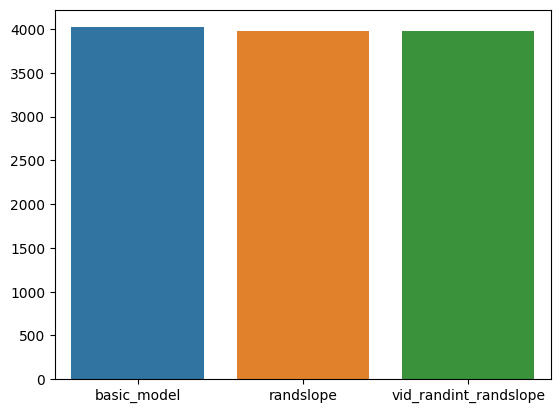

In [63]:
#test random effects
#vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False) CONVERGENCE WARNING
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': ['CONVERGENCE WARNING'], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, randslope is best

   no_covariate  age_covariate  sex_covariate  sex_age_covariate
0   3973.610918    3977.325777    3979.800686          3983.5667


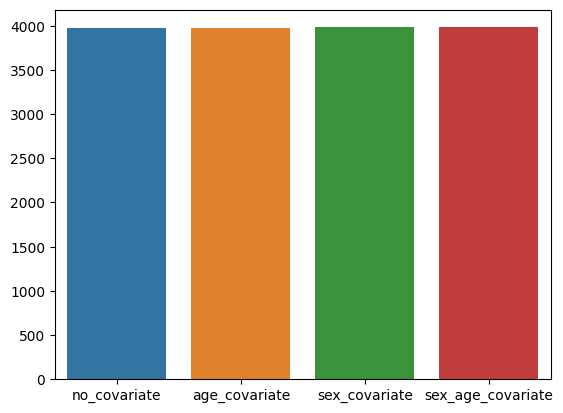

In [65]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, no covariate is best

In [66]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Mixed Linear Model Regression Results
=========================================================================================
Model:                       MixedLM           Dependent Variable:           disgusting_1
No. Observations:            1020              Method:                       ML          
No. Groups:                  340               Scale:                        1.5447      
Min. group size:             3                 Log-Likelihood:               -1952.1677  
Max. group size:             3                 Converged:                    Yes         
Mean group size:             3.0                                                         
-----------------------------------------------------------------------------------------
                                              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------
Intercept                                      6.194    0.083  74.777 0.000  6.032  6.356
trial_type[T.fear]                            -5.179    0.104 -49.887 0.000 -5.383 -4.976
trial_type[T.points]                          -4.921    0.138 -35.629 0.000 -5.191 -4.650
Group Var                                      0.788                                     
Group x trial_type[T.fear] Cov                -0.370                                     
trial_type[T.fear] Var                         0.575                                     
Group x trial_type[T.points] Cov              -0.594                                     
trial_type[T.fear] x trial_type[T.points] Cov  1.267                                     
trial_type[T.points] Var                       3.395                                     
=========================================================================================

"""

Model H: frightening_1 ~ trial_type

In [67]:
#Model H
formula = 'frightening_1 ~ trial_type'
model=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop')
basic_model=model.fit(reml=False)

In [69]:
vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False)

u:\Documents\envs\disgust_reversal_venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


   basic_model          vid_randint    randslope  vid_randint_randslope
0  4211.214517  CONVERGENCE WARNING  4226.831409            4233.758964


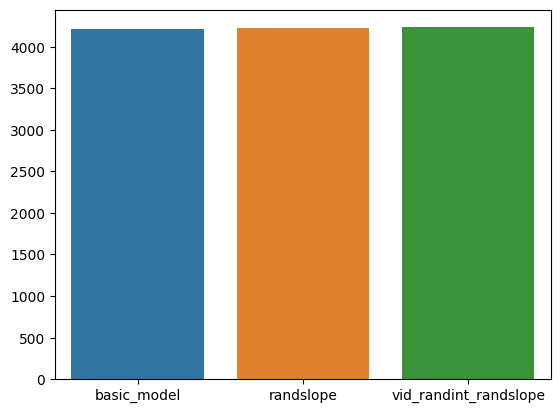

In [72]:
#test random effects
#vid_randint=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}).fit(reml=False) CONVERGENCE WARNING
randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', re_formula='~trial_type').fit(reml=False)
vid_randint_randslope=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop', vc_formula={'Vid': '0+Vid'}, re_formula='~trial_type').fit(reml=False)

bic=pd.DataFrame({'basic_model': [basic_model.bic], 
                    'vid_randint': ['CONVERGENCE WARNING'], 
                    'randslope': [randslope.bic],
                    'vid_randint_randslope':[vid_randint_randslope.bic]})
sns.barplot(bic)
print(bic) ##in this case, basic model is best

   age_covariate  no_covariate  sex_age_covariate  sex_covariate
0    4207.540556   4211.214517        4214.350594    4218.069565


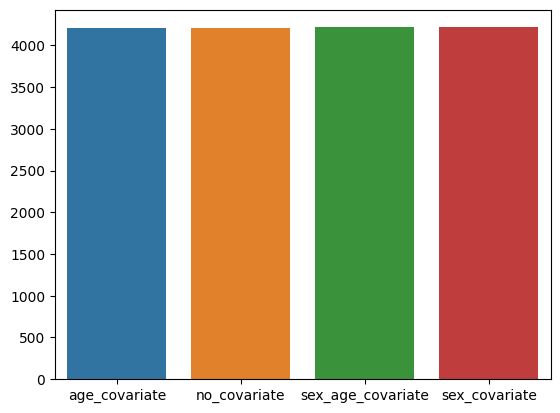

In [74]:
#test covariates
no_covariate=smf.mixedlm(formula, data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_covariate=smf.mixedlm(formula+str('+prolific_sex'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
age_covariate=smf.mixedlm(formula+str('+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)
sex_age_covariate=smf.mixedlm(formula+str('+prolific_sex+prolific_age'), data, groups=data['participant_no'], missing='drop').fit(reml=False)

bic=pd.DataFrame({'no_covariate': [no_covariate.bic], 
                    'sex_covariate': [sex_covariate.bic], 
                    'age_covariate': [age_covariate.bic],
                    'sex_age_covariate': [sex_age_covariate.bic]})
sns.barplot(bic.sort_values(by=0, axis=1))
print(bic.sort_values(by=0, axis=1)) ##in this case, age covariate is best

In [75]:
#Hypothesis test
age_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM  Dependent Variable:  frightening_1
No. Observations:   1020     Method:              ML           
No. Groups:         340      Scale:               2.7267       
Min. group size:    3        Log-Likelihood:      -2082.9876   
Max. group size:    3        Converged:           Yes          
Mean group size:    3.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.092    0.246  8.512 0.000  1.610  2.573
trial_type[T.fear]    4.268    0.127 33.697 0.000  4.019  4.516
trial_type[T.points] -0.050    0.127 -0.395 0.693 -0.298  0.198
prolific_age         -0.016    0.005 -3.282 0.001 -0.026 -0.007
Group Var             0.977    0.107                           
===============================================================

"""

In [76]:
#Hypothesis test
no_covariate.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM  Dependent Variable:  frightening_1
No. Observations:   1020     Method:              ML           
No. Groups:         340      Scale:               2.7267       
Min. group size:    3        Log-Likelihood:      -2088.2884   
Max. group size:    3        Converged:           Yes          
Mean group size:    3.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             1.362    0.105 12.943 0.000  1.156  1.568
trial_type[T.fear]    4.268    0.127 33.697 0.000  4.019  4.516
trial_type[T.points] -0.050    0.127 -0.395 0.693 -0.298  0.198
Group Var             1.037    0.111                           
===============================================================

"""

<b>Interpretation of these models:</b>
<li>Expect points to differ from fear vs disgust in all 4 models (i.e.. an effect of feedback type in models E-H)

Text(313.26767676767673, 0.5, 'Fear')

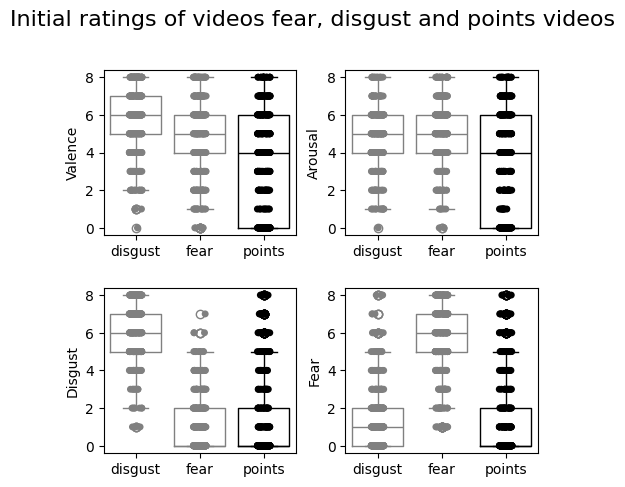

In [78]:
#example plot for this data
data=chosen_stim_df[['participant_no', 'trial_type', 'unpleasant_1', 'arousing_1', 'disgusting_1', 'frightening_1']].sort_values('trial_type')
fig, axes = plt.subplots(2,2)
title="Initial ratings of videos fear, disgust and points videos"
plt.suptitle(title, fontsize=16)
fig.tight_layout(pad=1.5)
fig.set_size_inches(5, 5)

order=['fear', 'disgust', 'points']
palette = {'fear': '0.5',
            'disgust': '0.5',
            'points': '0'}
sns.boxplot(data=data, ax=axes[0,0],   x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[0,0],  x='trial_type', hue='trial_type', y='unpleasant_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,0].set_xlabel('')
axes[0,0].set_ylabel('Valence')

sns.boxplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[0,1], x='trial_type', hue='trial_type', y='arousing_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[0,1].set_xlabel('')
axes[0,1].set_ylabel('Arousal')

sns.boxplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[1,0], x='trial_type', hue='trial_type', y='disgusting_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Disgust')

sns.boxplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type', y='frightening_1', palette=palette, legend=False, fill=False, linewidth=1, hue_order=order)
sns.stripplot(data=data, ax=axes[1,1], x='trial_type',  hue='trial_type',  y='frightening_1', palette=palette, legend=False, dodge=False, hue_order=order)
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('Fear')